# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import torch
import transformers

import spacy

import re
import string
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer

from lightgbm import LGBMClassifier




nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm.auto import tqdm

ModuleNotFoundError: No module named 'transformers'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [4]:
df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

In [6]:
df_reviews.info()

In [7]:
df_reviews.isna().sum()

In [8]:
df_reviews.dropna(inplace=True)

In [9]:
df_reviews.duplicated().sum()

In [10]:
# Verificando o balanceamento das avaliações
df_reviews['pos'].value_counts()

## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

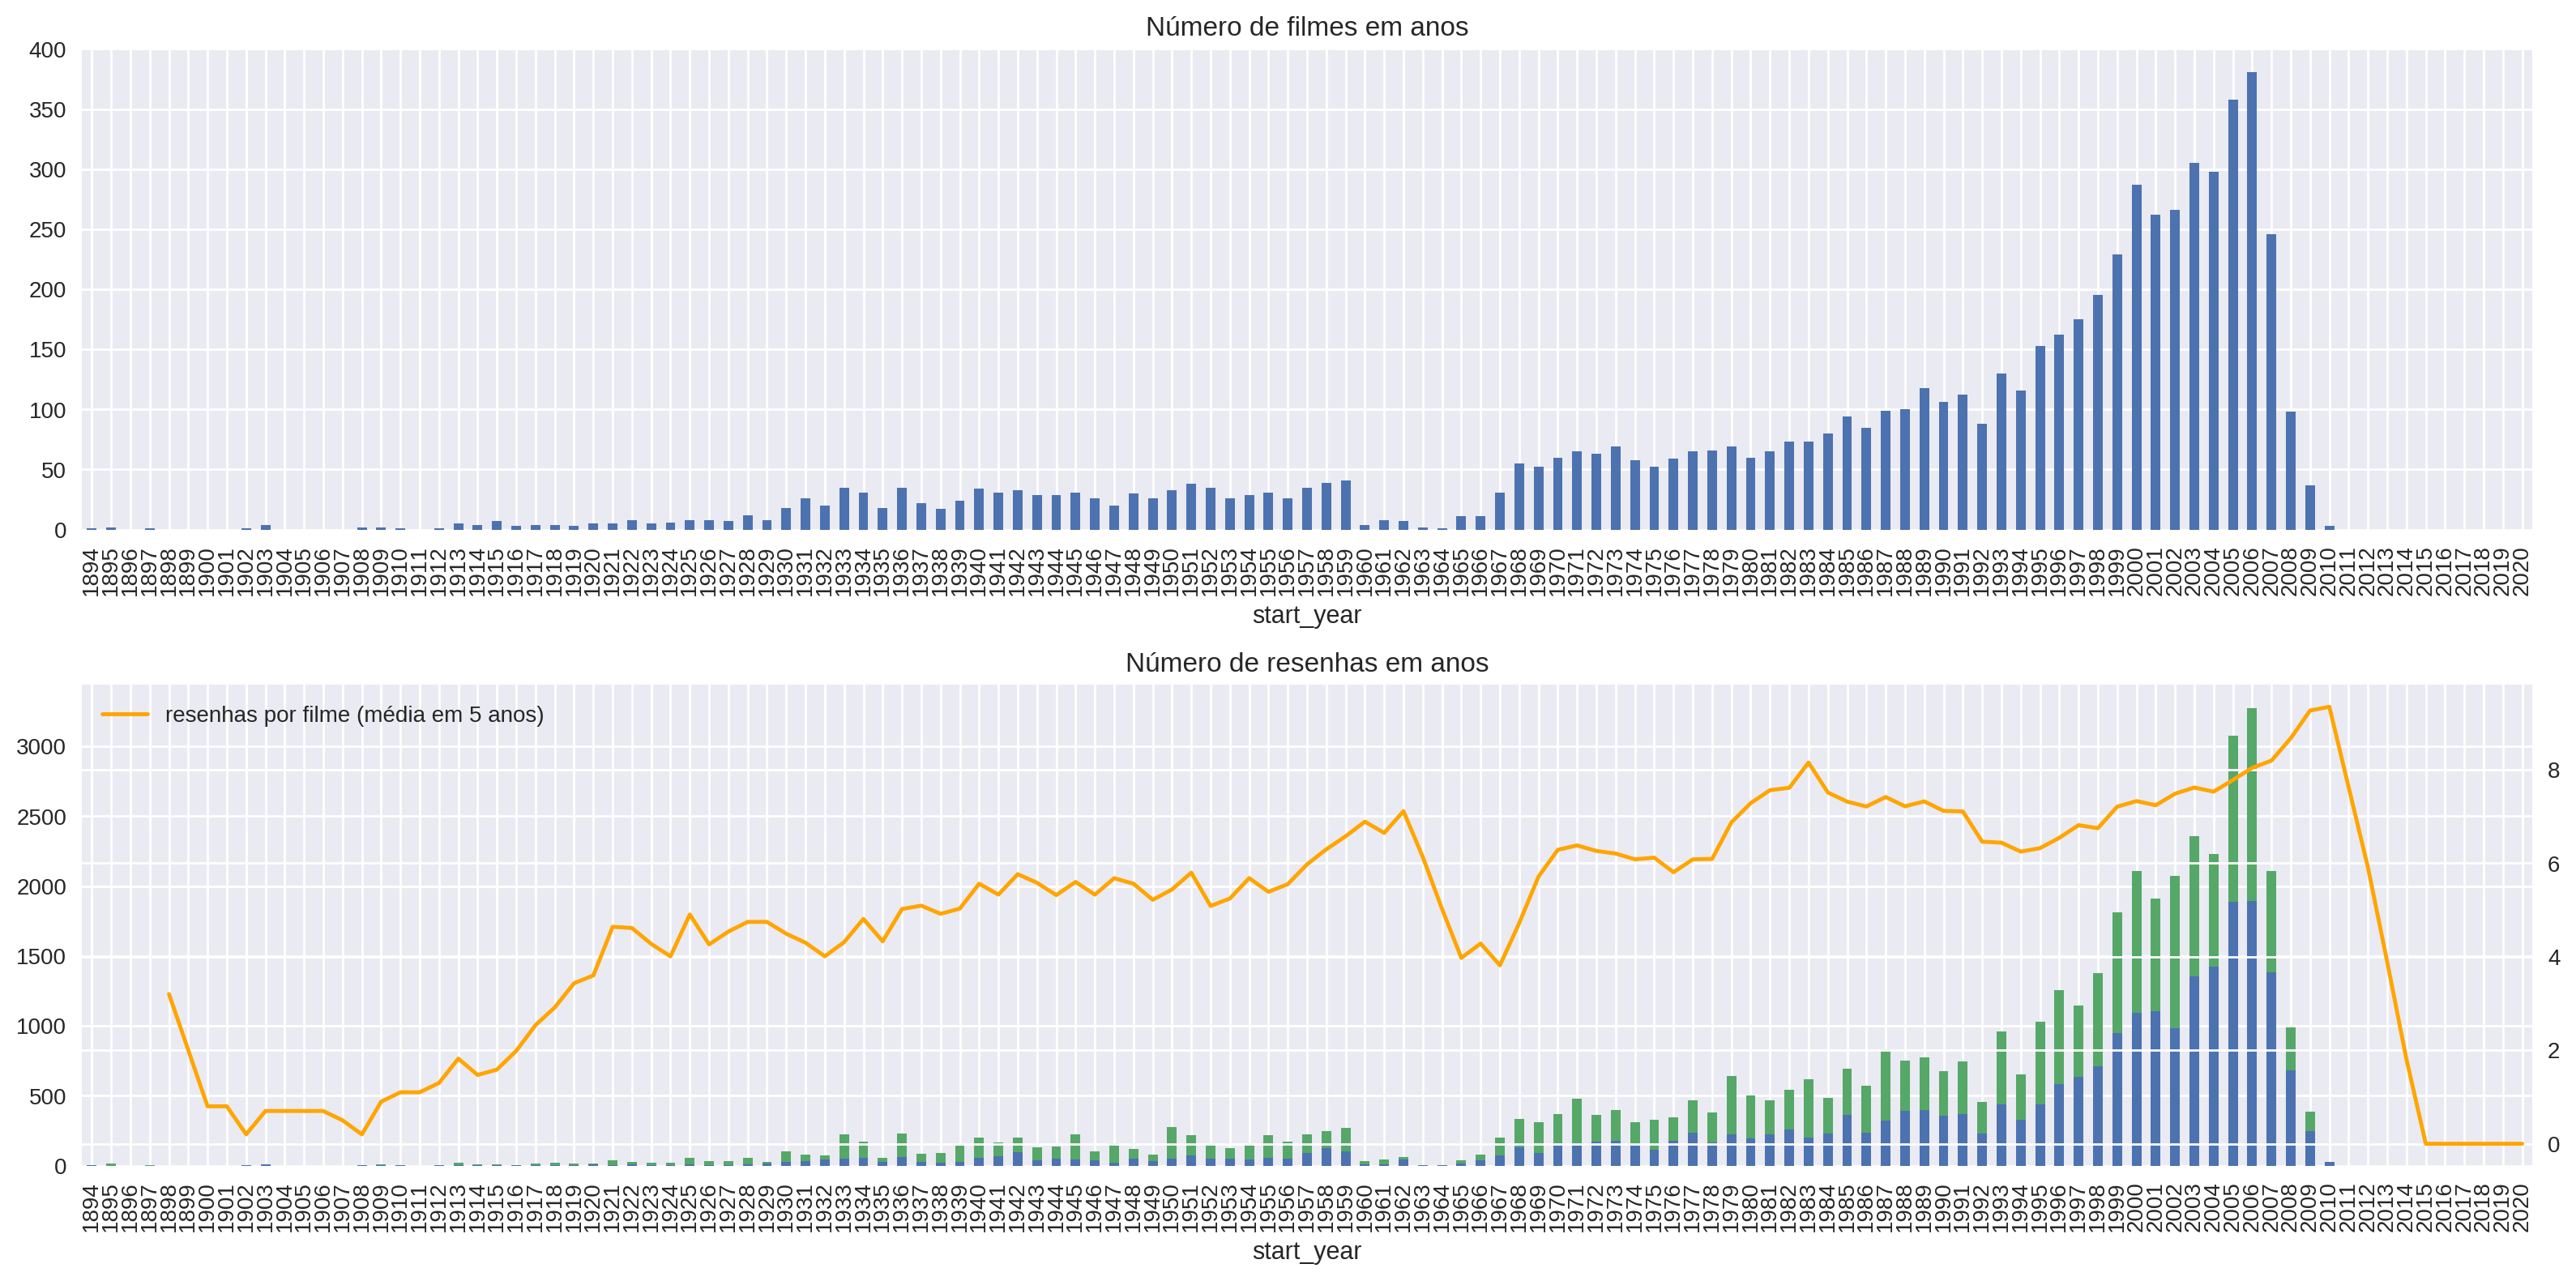

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

# Verifica-se, pela análise dos dois gráficos acima, que o número de resenhas sofreu um grande aumentos nos anos mais recentes, o que pode se dar pela disseminação do uso da internet e redes sociais. O acesso a essas ferramentas possibilitou a mais pessoas pulicarem suas resenhas e se fazerem lidos.


Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

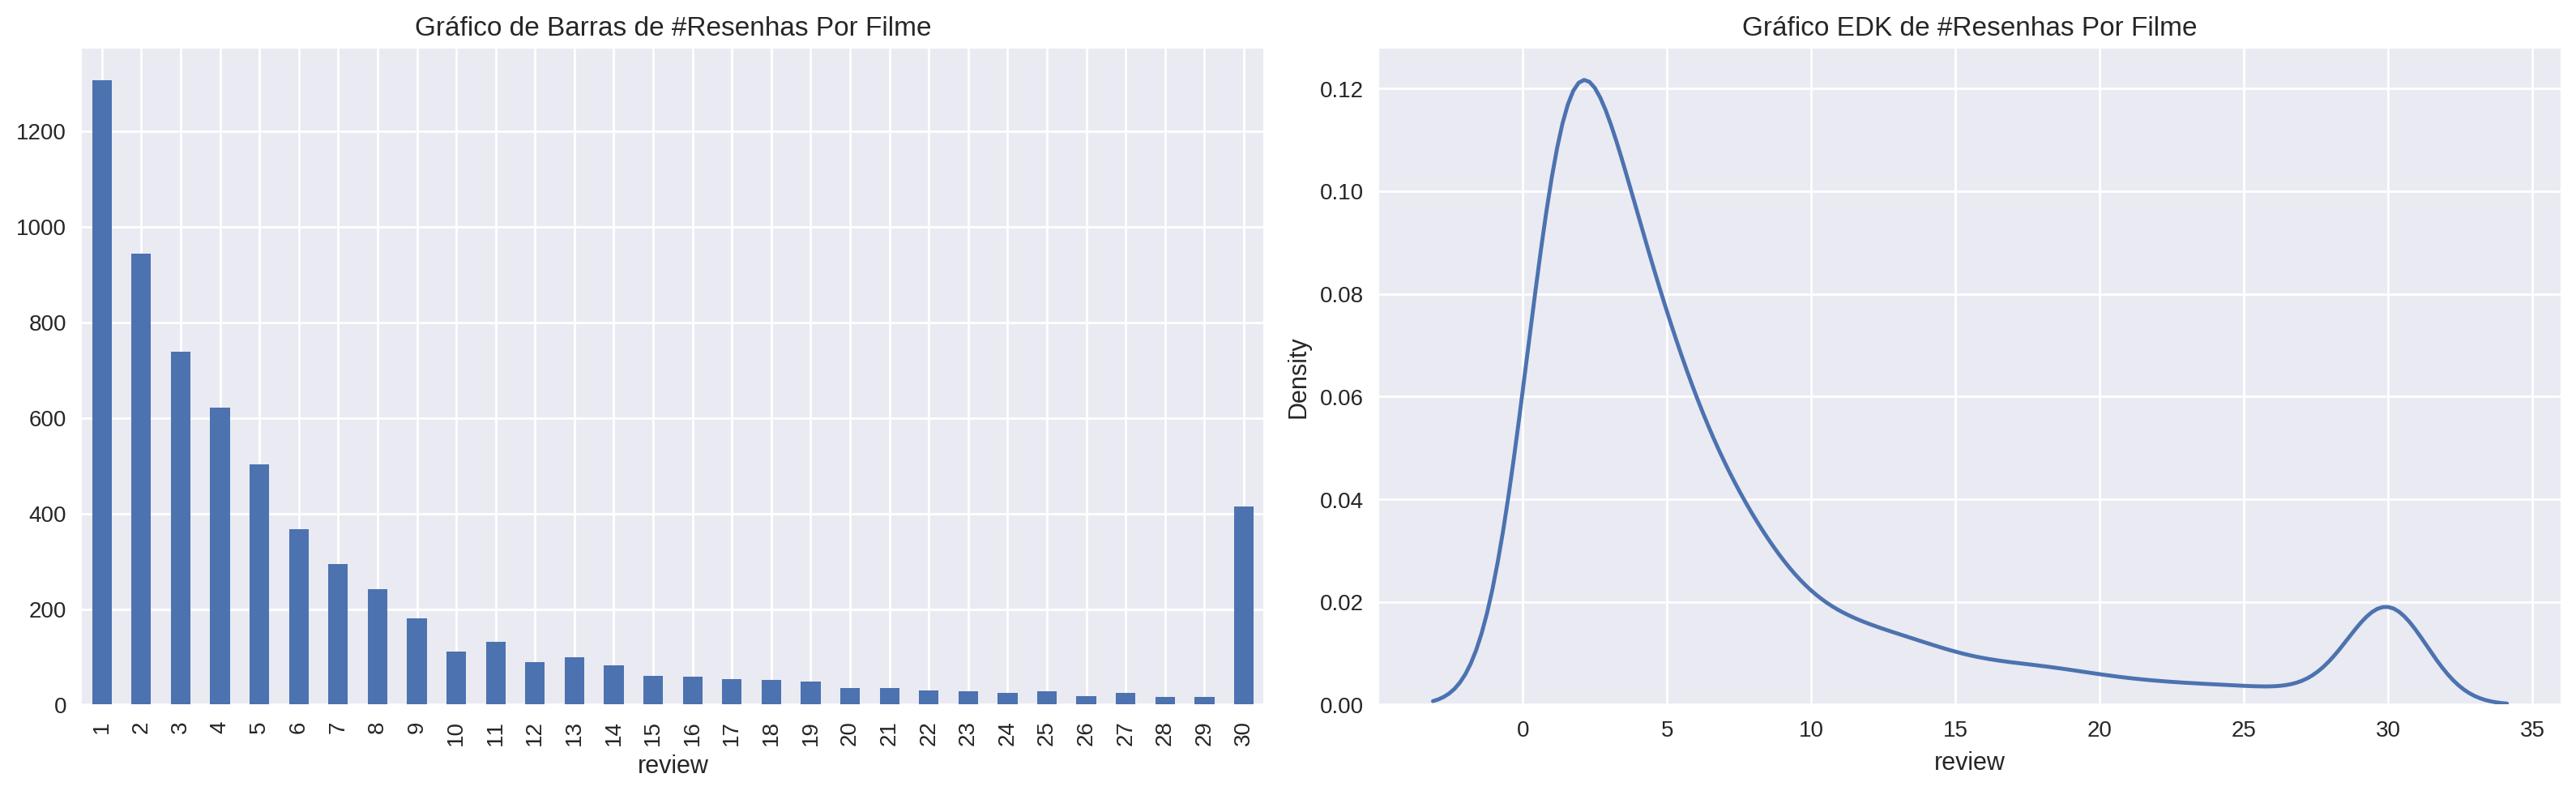

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

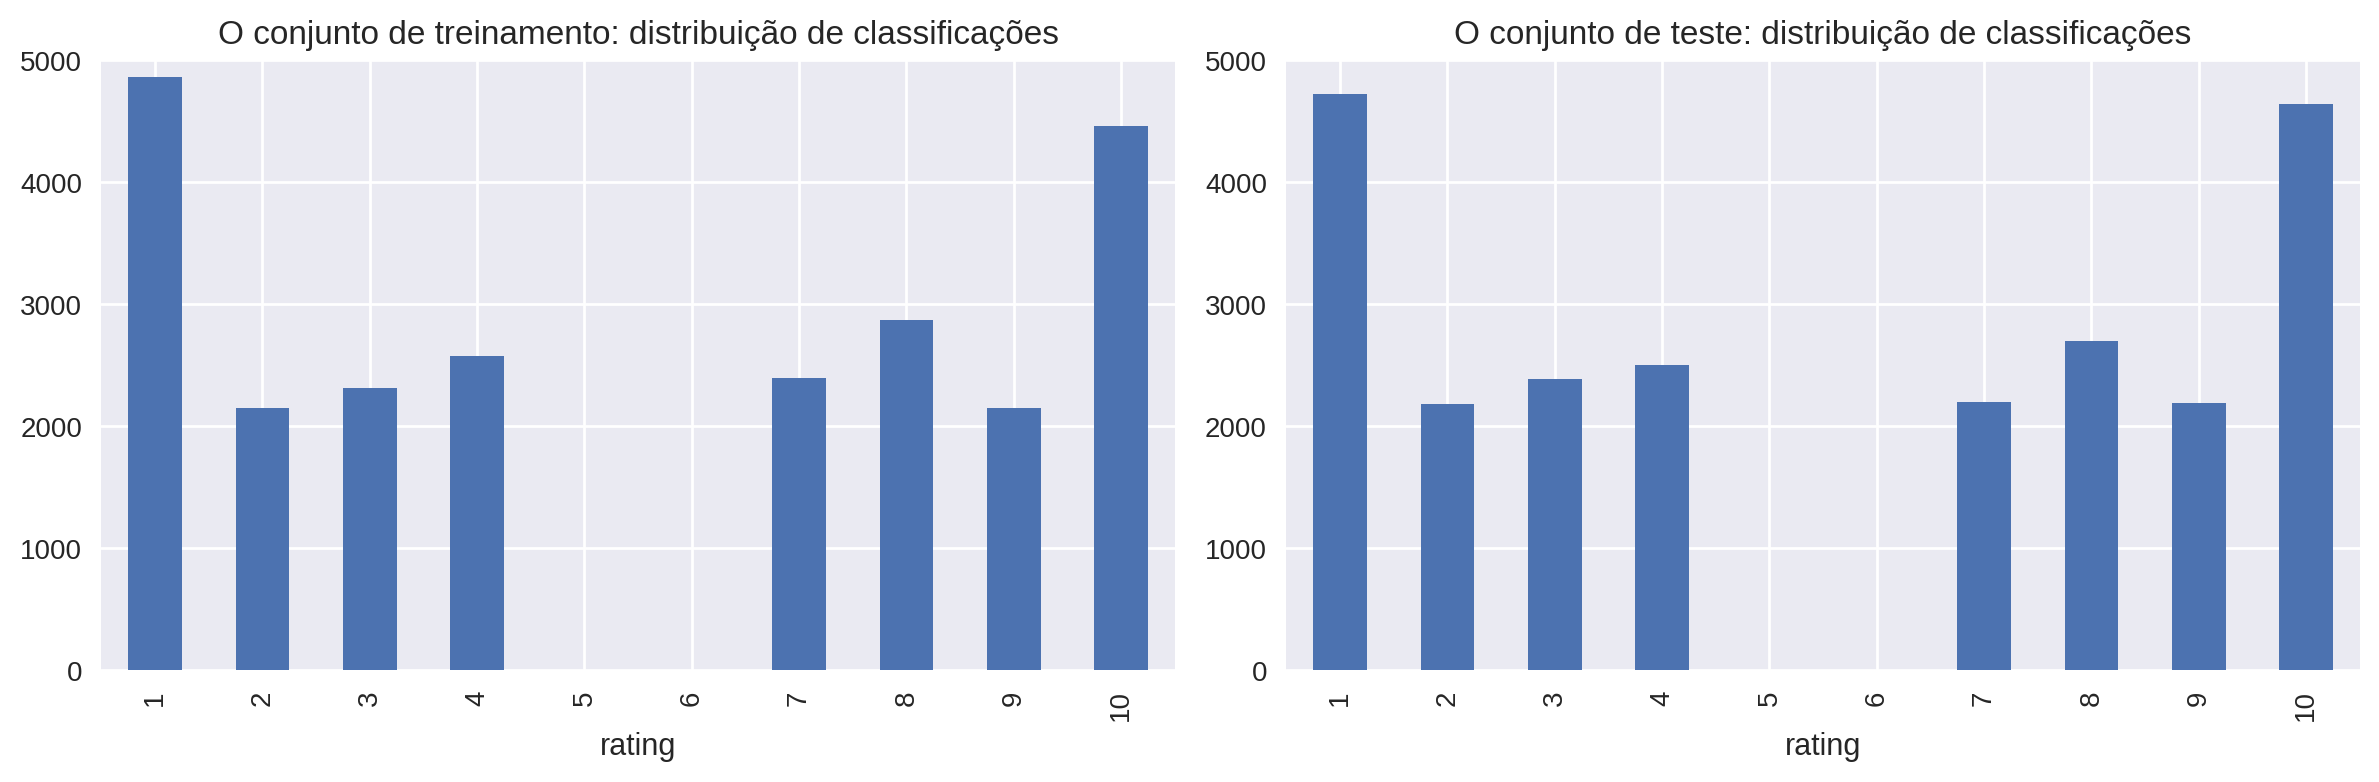

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

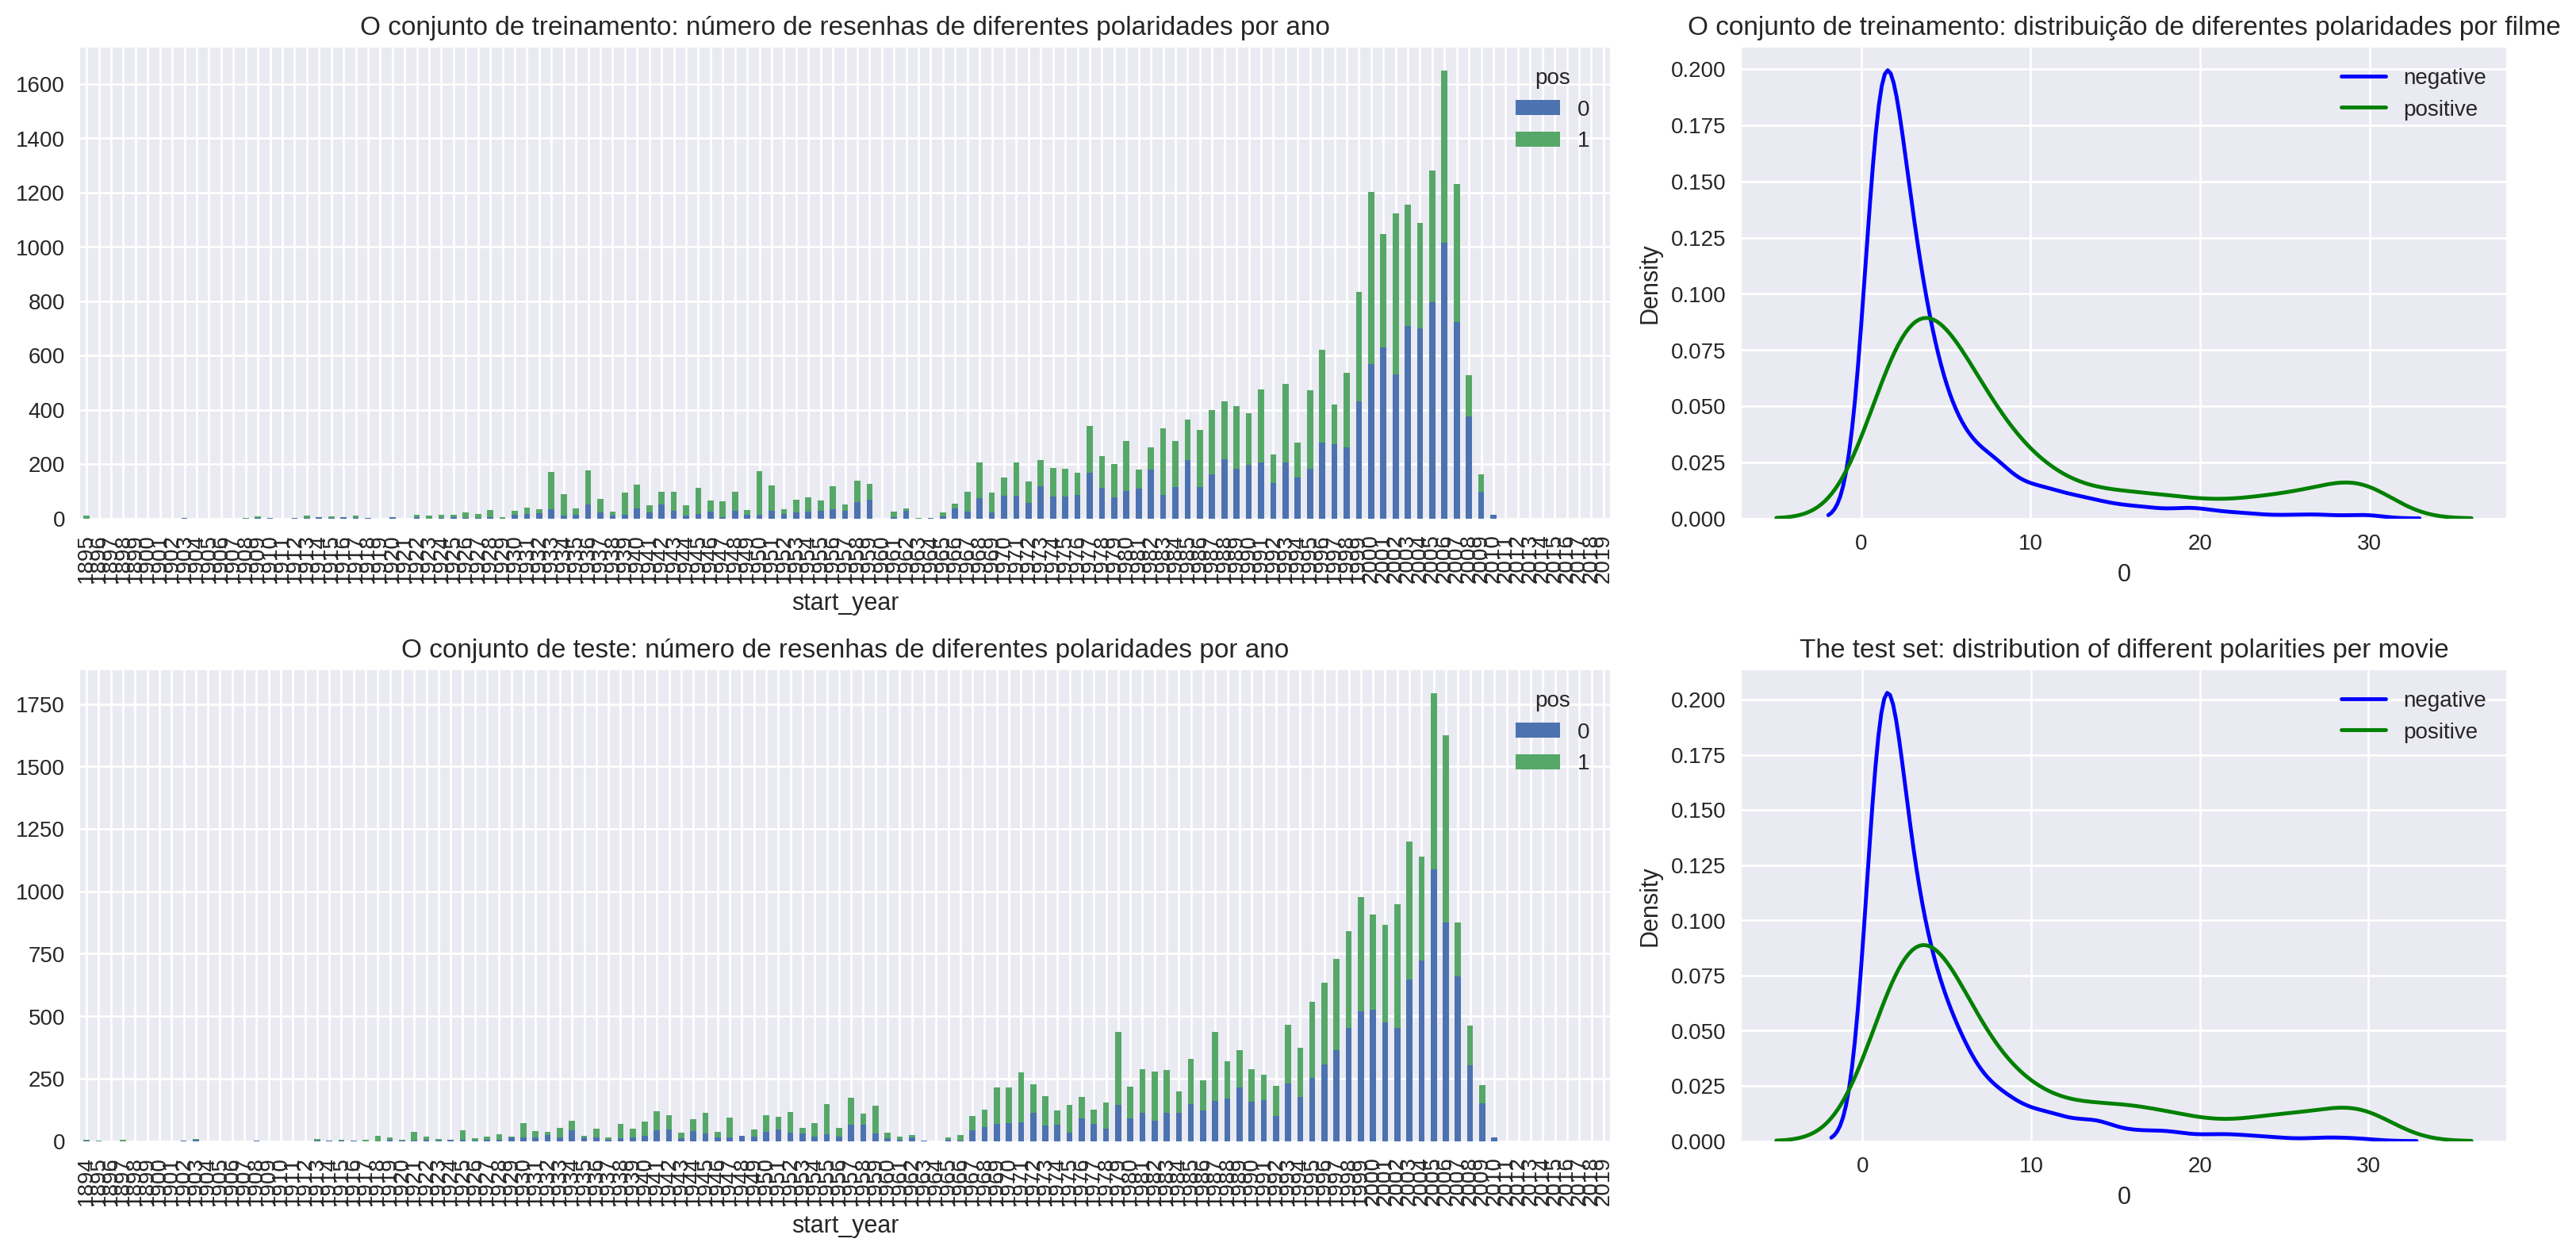

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

# Os gráficos mostram que os conjuntos de treinamento e teste possuem uma distribuição parecida, mostrando a consistência dos dados.


## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for data_type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[data_type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1 Score
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # Store the maximum F1 score and its corresponding threshold
        max_f1_score_idx = np.argmax(f1_scores)
        eval_stats[data_type]['F1 Score'] = f1_scores[max_f1_score_idx]

        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[data_type]['ROC AUC'] = roc_auc

        # Precision-Recall Curve
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[data_type]['APS'] = aps

        color = 'blue' if data_type == 'train' else 'green'

        # F1 Score Plot
        ax = axs[0]
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{data_type}, max F1={f1_scores[max_f1_score_idx]:.2f} @ threshold={f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score vs Threshold')

        # ROC Curve Plot
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')
        ax.set_title('ROC Curve')

        # Precision-Recall Curve Plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')

        eval_stats[data_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=['Accuracy', 'F1 Score', 'APS', 'ROC AUC'])

    print(df_eval_stats)

    plt.tight_layout()
    plt.show()

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [17]:
def normalize_text_for_sentiment(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\']', ' ', text)

    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()

    stop_words = set(nltk_stopwords.words('english'))

    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    normalized_text = ' '.join(tokens)

    return normalized_text

In [18]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text_for_sentiment)   # <coloque seu código aqui>

## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

## Trabalhando com modelos

### Modelo 0 - Constante

In [20]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [21]:
count_vectorizer = CountVectorizer(stop_words='english')
X_train_bow = count_vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_bow = count_vectorizer.transform(df_reviews_test['review_norm'])

In [22]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_tfidf = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

In [23]:
dummy_clf.fit(X_train_tfidf, train_target)
dummy_pred = dummy_clf.predict(X_test_tfidf)

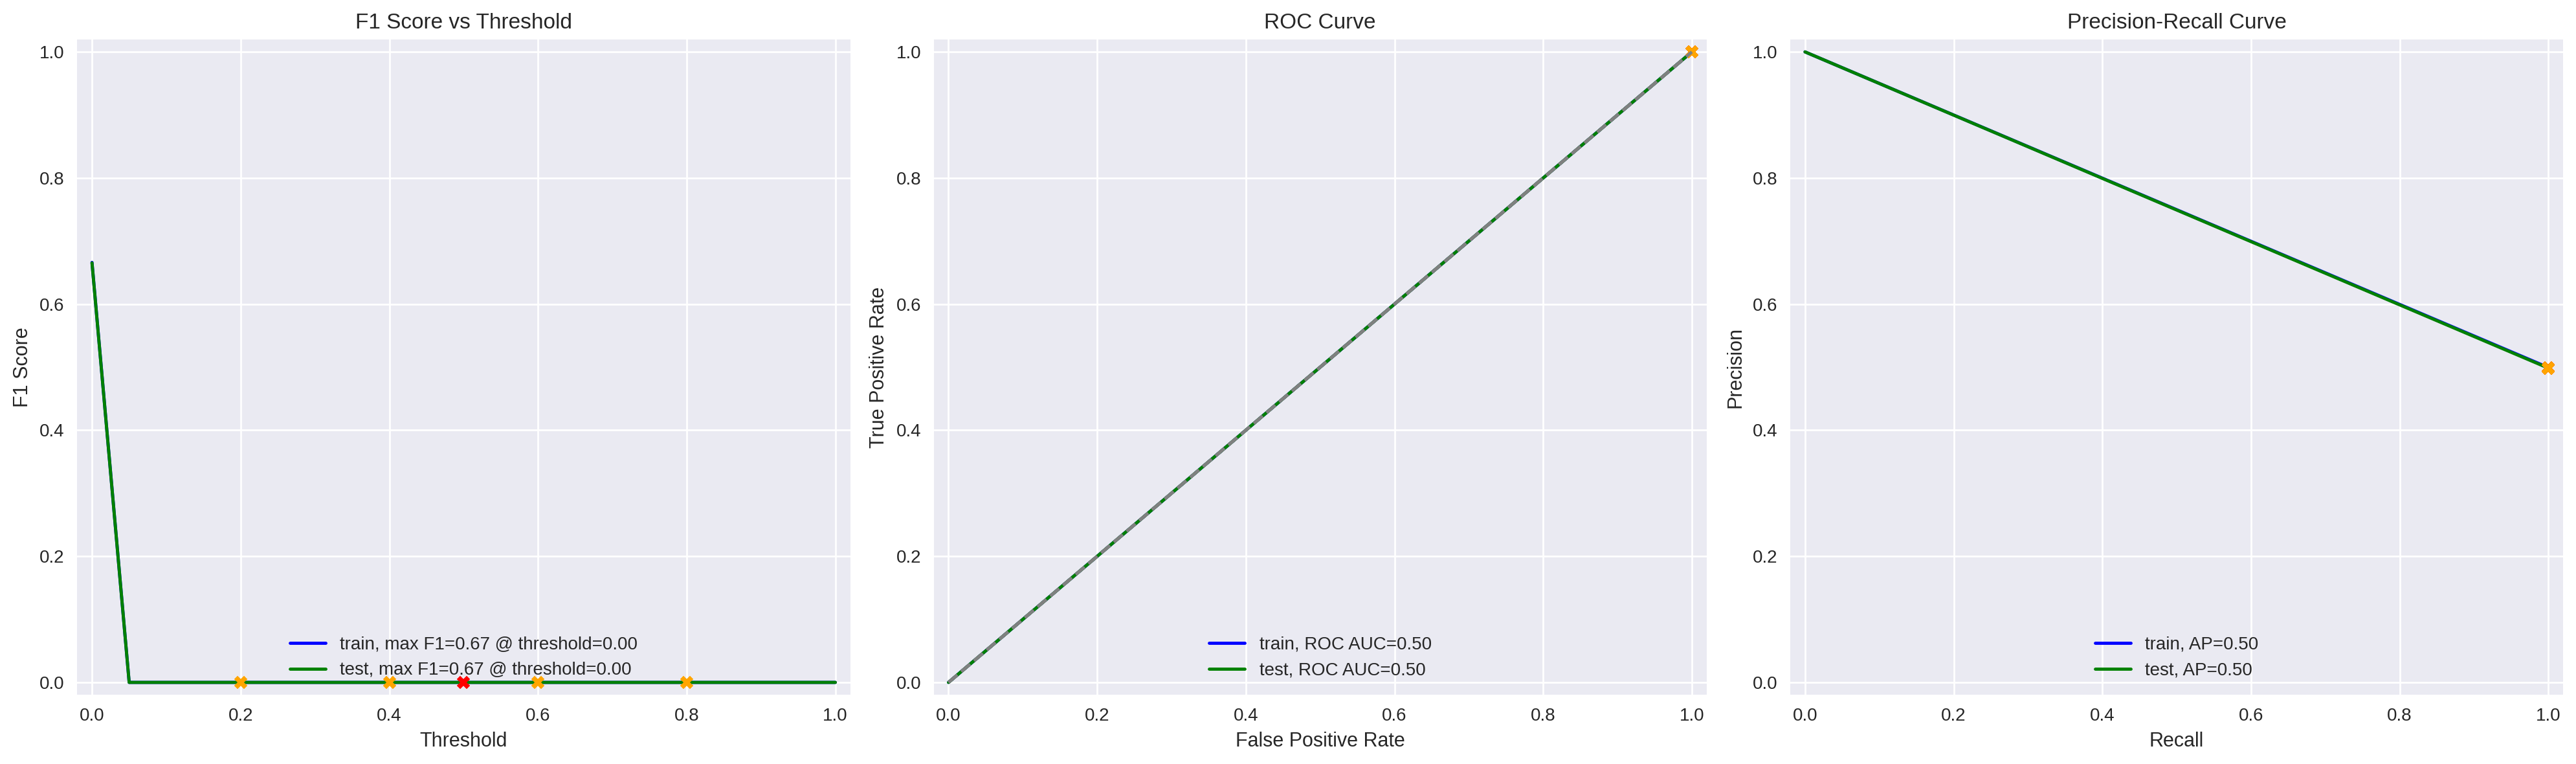

In [24]:
print(accuracy_score(test_target, dummy_pred))
print(f1_score(test_target, dummy_pred))
evaluate_model(dummy_clf, X_train_tfidf, train_target, X_test_tfidf, test_target)

# Acurácia e F1 calculadas.

### Modelo 1 - NLTK, TF-IDF e Regressão Linear

TF-IDF

In [25]:
train_corpus = df_reviews_train['review_norm']
target_train = df_reviews_train['pos']


test_corpus = df_reviews_test['review_norm']

count_tf_idf = TfidfVectorizer(stop_words='english')

tf_idf = count_tf_idf.fit_transform(train_corpus)

features_train = tf_idf
target_train = df_reviews_train['pos']

features_test = count_tf_idf.transform(test_corpus)

In [26]:
lr = LinearRegression()
lr.fit(features_train, target_train)
pred_test = lr.predict(features_test)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

In [27]:
# evaluate_model(lr, features_train, target_train, features_test, test_target)

# Nesse caso, por ser regressão linear, a função dá erro.

### Modelo 2 - NLTK, TF-IDF e Regressão Logística


In [28]:
log = LogisticRegression()
log.fit(features_train, target_train)
pred_test = log.predict(features_test)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

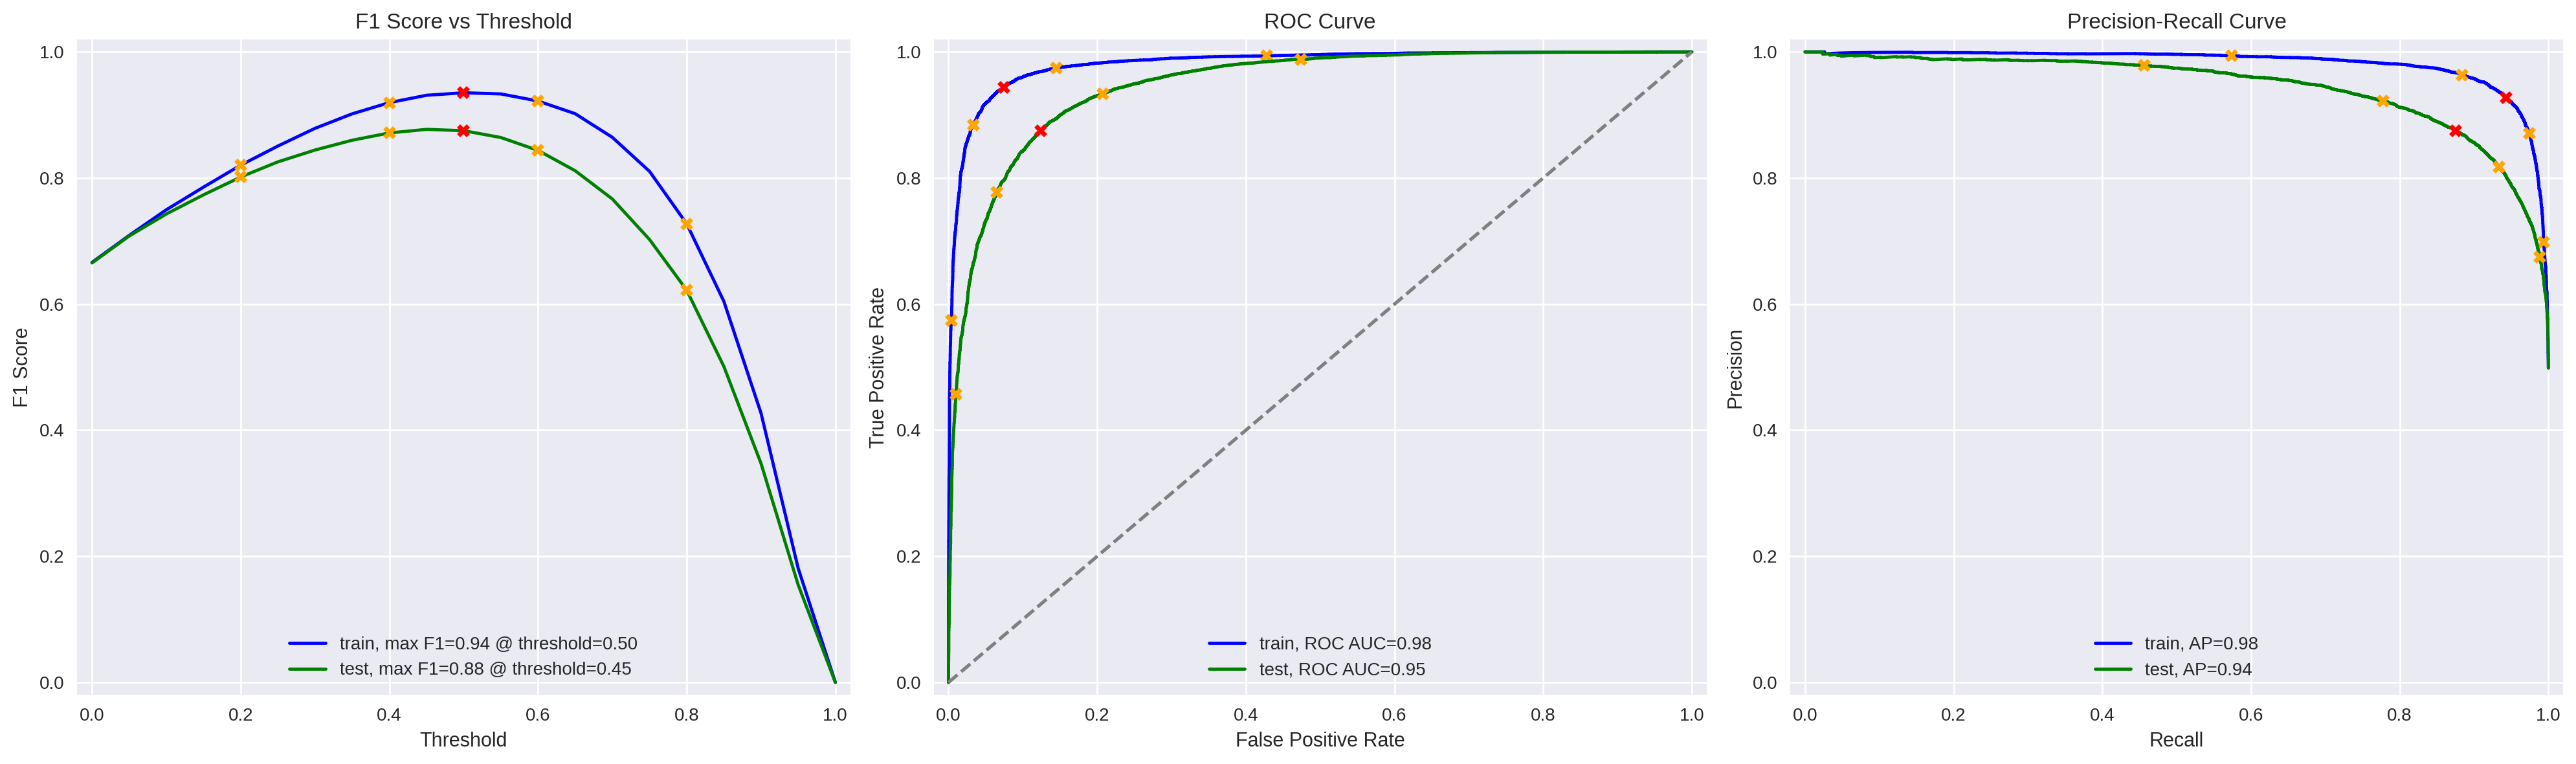

In [29]:
evaluate_model(log, features_train, target_train, features_test, test_target)

### Modelo 3 - spaCy, TF-IDF e Regressão Linear

In [30]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [31]:
def text_preprocessing_3(text):

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [32]:
def clear_text(text):
    clean_text = re.sub(r'[^a-zA-Z\']', ' ', text)
    clean_text = ' '.join(clean_text.split())

    return clean_text

In [33]:
df_reviews_m3 = df_reviews.copy()
df_reviews_m3['review_norm'] = df_reviews_m3['review'].apply(clear_text)

In [34]:
df_reviews_m3 = df_reviews.copy()
df_reviews_m3['review_norm'] = df_reviews_m3['review'].apply(clear_text)

In [35]:
df_reviews_m3_train = df_reviews_m3.query('ds_part == "train"').copy()
df_reviews_m3_test = df_reviews_m3.query('ds_part == "test"').copy()

train_target = df_reviews_m3_train['pos']
test_target = df_reviews_m3_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

In [36]:
train_data3 = df_reviews_m3_train
test_data3 = df_reviews_m3_test

train_corpus3 = df_reviews_m3_train['review_norm']
stop_words = list(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit_transform(train_corpus3)

features_train3 = tf_idf
target_train3 = train_data3.pos

test_corpus3 = df_reviews_m3_test['review_norm']
features_test3 = count_tf_idf.transform(test_corpus3)


In [37]:
lr = LinearRegression()
lr.fit(features_train3, target_train3)
pred_test = lr.predict(features_test3)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

In [38]:
# evaluate_model(lr, features_train3, target_train3, features_test3, test_target)

### Modelo 4 - spaCy, TF-IDF e Regressão Logística

In [46]:
log_3 = LogisticRegression()
log_3.fit(features_train3, target_train3)
pred_test = log_3.predict(features_test3)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

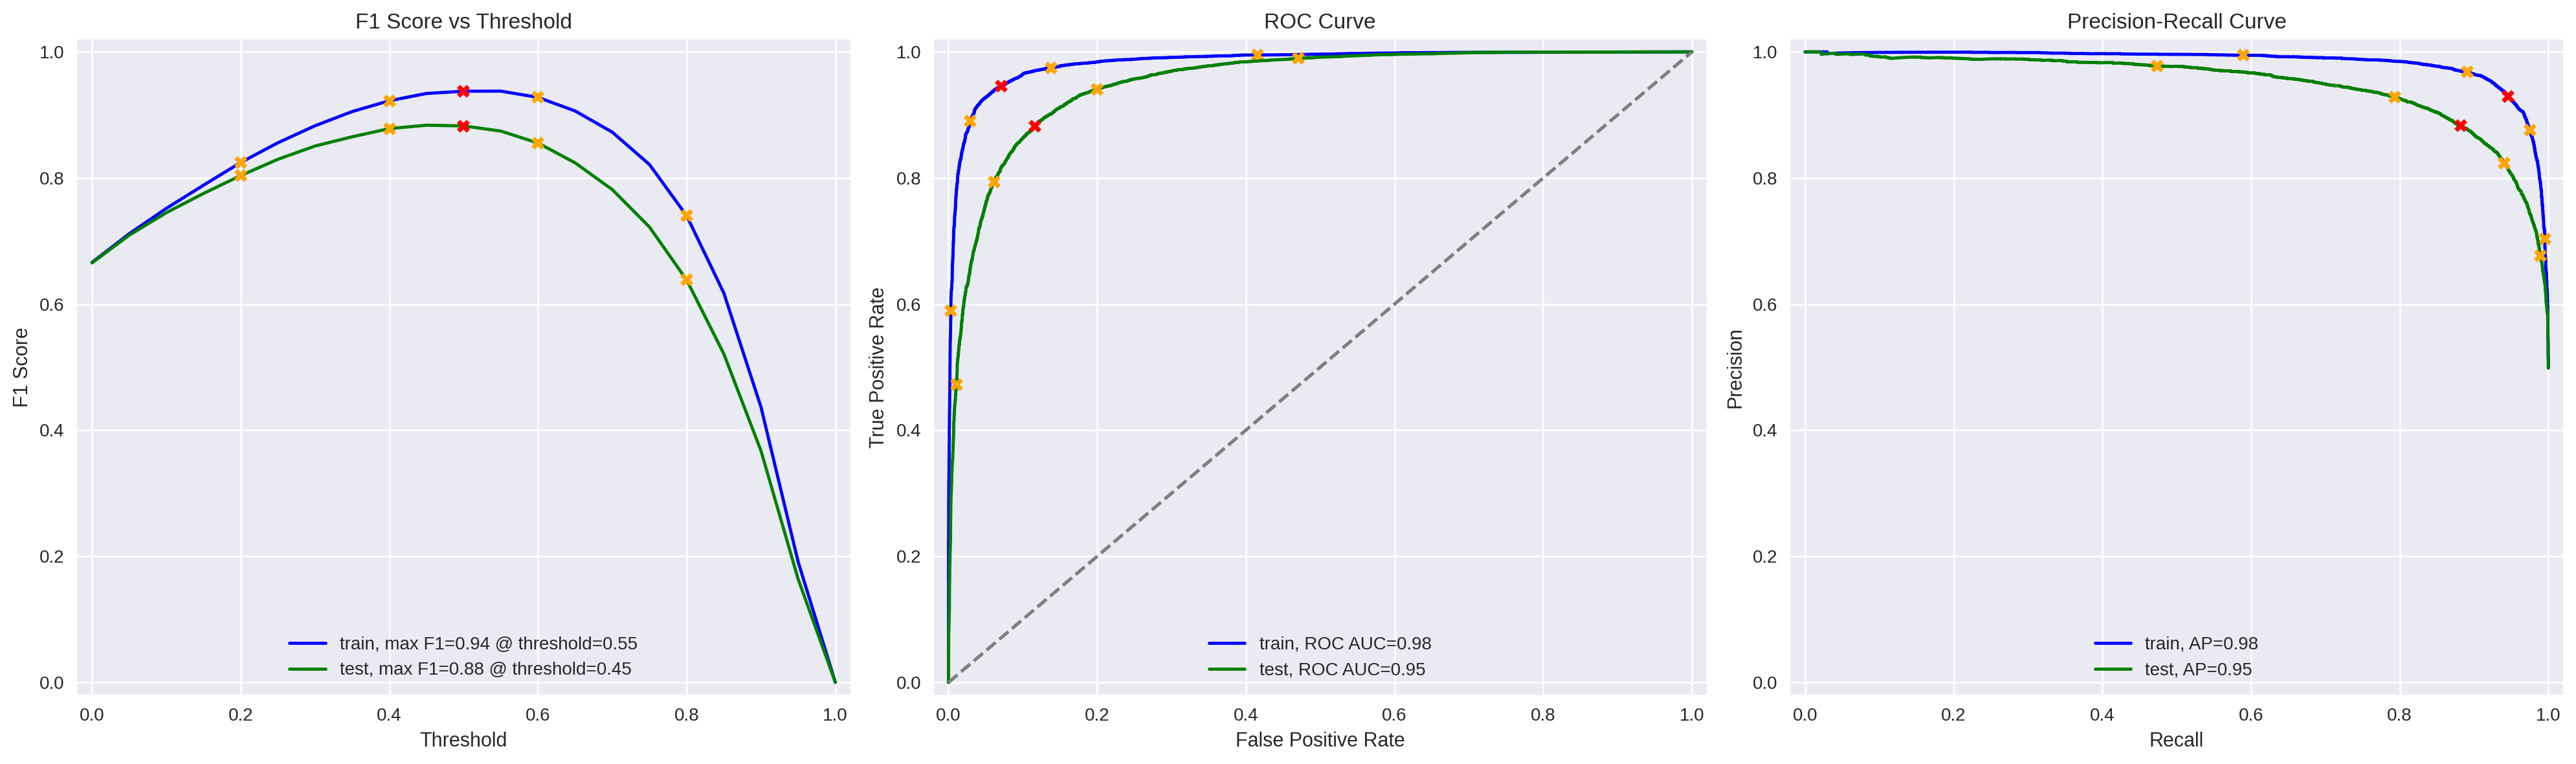

In [47]:
evaluate_model(log_3, features_train3, target_train3, features_test3, test_target)

### Modelo 5 - SpaCy, TF-IDF e LGBMClassifier

In [48]:
from lightgbm import LGBMClassifier

In [49]:
lgbm = LGBMClassifier()
lgbm.fit(features_train, target_train)
pred_test = lgbm.predict(features_test)

submission = pd.DataFrame({'pos':pred_test})
print(submission)

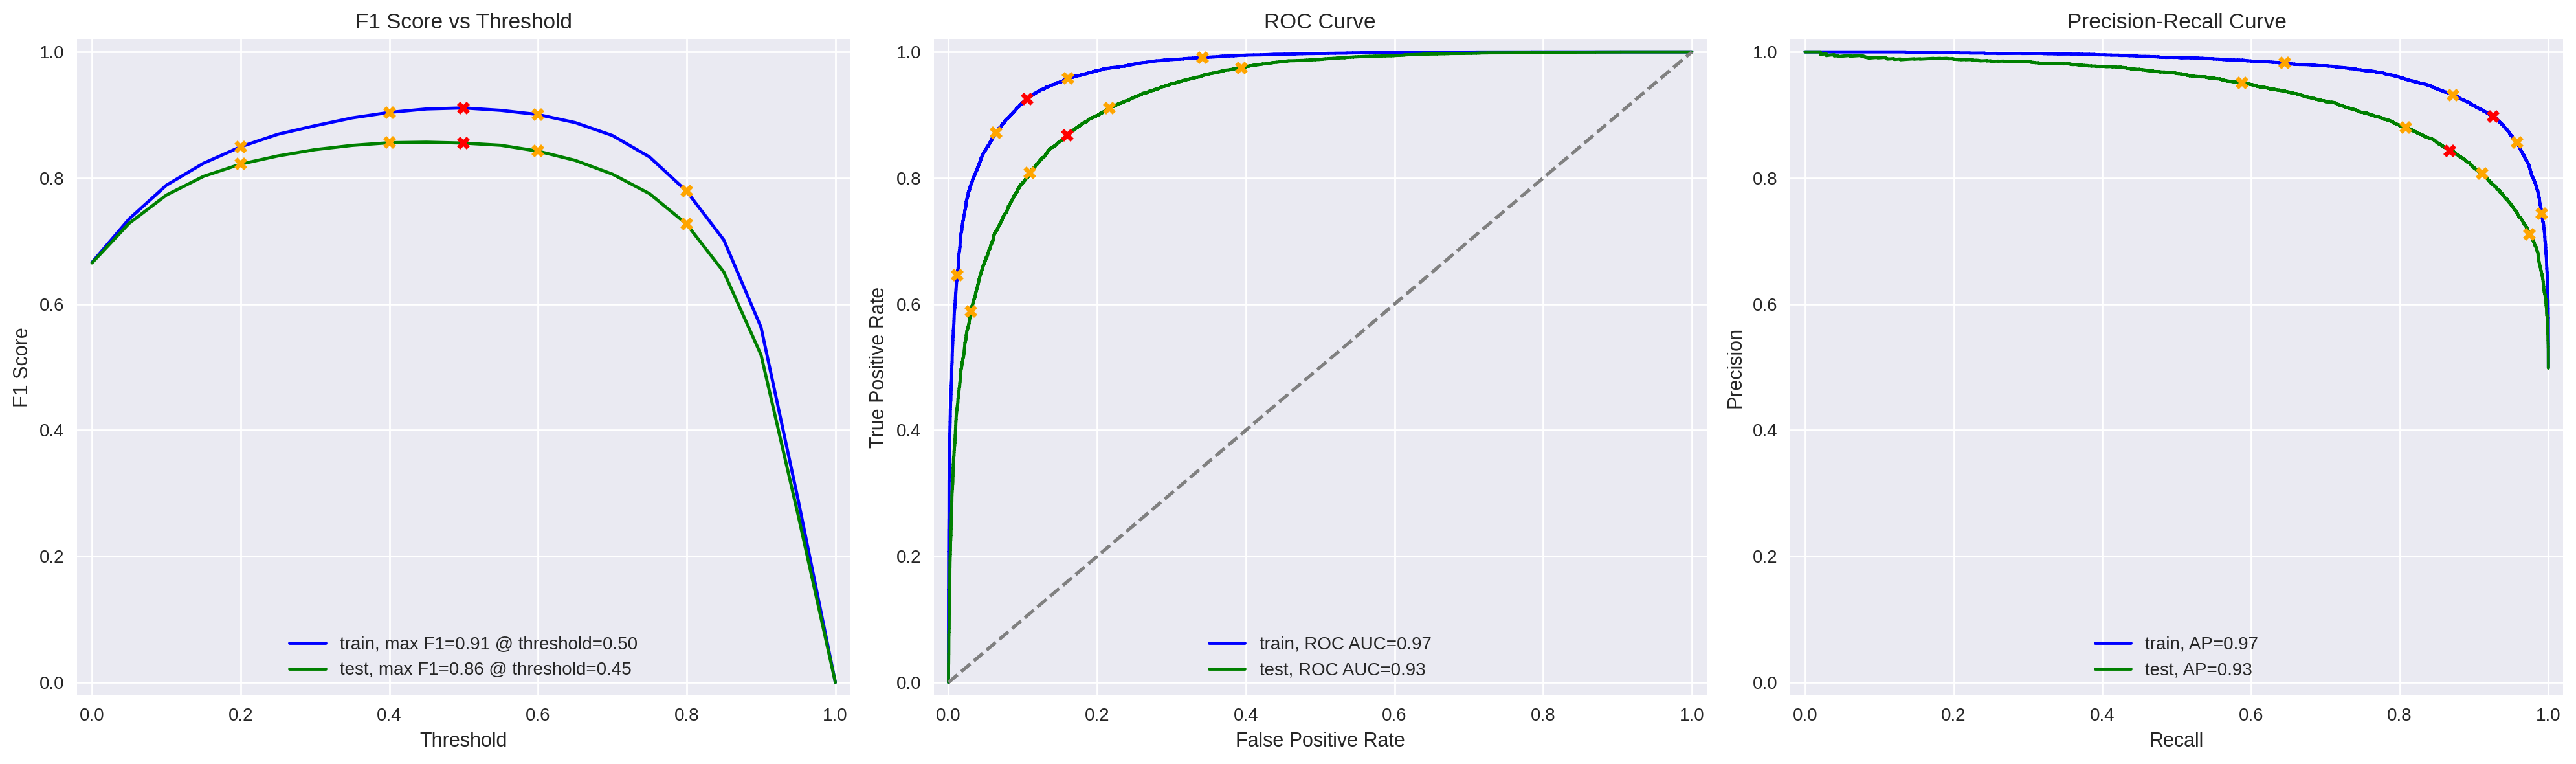

In [50]:
evaluate_model(lgbm, features_train, train_target, features_test, test_target)

###  Modelo 6 - BERT

In [51]:
import torch
import transformers
from transformers import BertTokenizer

In [52]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [53]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')

    ids_list = []
    attention_mask_list = []

    # texto para IDs de tokens preenchidos com suas máscaras de atenção

    for input_text in tqdm(texts, disable=disable_progress_bar):
      ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
      padded = np.array(ids + [0]*(max_length - len(ids)))
      attention_mask = np.where(padded != 0, 1, 0)
      ids_list.append(padded)
      attention_mask_list.append(attention_mask)


    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Usando o dispositivo {device}.')


    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <coloque seu código aqui para criar attention_mask_batch
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [54]:
# Atenção! A execução do BERT para milhares de textos pode levar muito tempo na CPU, pelo menos várias horas
train_features_6 = BERT_text_to_embeddings(df_reviews['review_norm'], force_device='cuda')
target = df_reviews['pos']

In [55]:
train_features_bert, test_features_bert, train_target_bert, test_target_bert = train_test_split(train_features_6, target, test_size=0.2, random_state=42)

In [56]:
print(df_reviews_train['review_norm'].shape)
print(train_features_6.shape)
print(train_target.shape)

In [57]:
# se você tiver as incorporações, é aconselhável salvá-las para tê-las prontas se
np.savez_compressed('features_6.npz', train_features_6=train_features_6, test_features_6=test_features_bert)

# e carregar...
with np.load('features_6.npz') as data:
    train_features_6 = data['train_features_6']
    test_features_6 = data['test_features_6']

## Minhas Resenhas

In [58]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    "A heartwarming tale that hits all the right emotional notes without feeling forced.",
    "This film is a visual masterpiece, but the plot left much to be desired.",
    "A laugh-out-loud comedy that’s perfect for a weekend escape.",
    "While the action scenes are thrilling, the storyline feels a bit too predictable.",
    "An intense thriller that will keep you on the edge of your seat until the very end.",
    "Great performances, but the pacing made it drag in parts.",
    "A gripping story of survival, but the emotional depth wasn't fully explored.",
    "The chemistry between the leads makes this rom-com a joy to watch.",
    "Visually stunning, but the lack of character development holds it back.",
    "An ambitious film that delivers on style but falters in substance."

], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text_for_sentiment)# <coloque aqui a mesma lógica de normalização do conjunto de dados principal>

my_reviews

### Modelo 2

In [59]:

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text_for_sentiment)

train_texts = [
    "A heartwarming tale that hits all the right emotional notes.",
    "A visual masterpiece with a compelling plot.",
    "A comedy perfect for a weekend escape.",
    "An action-packed thriller with unexpected twists."
]
train_labels = [1, 1, 1, 0]


stop_words = list(nltk.corpus.stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

tf_idf_train = count_tf_idf.fit_transform(train_texts)

log = LogisticRegression()
log.fit(tf_idf_train, train_labels)

texts = my_reviews['review_norm']

texts_transformed = count_tf_idf.transform(texts)

my_reviews_pred_prob = log.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 3

### Modelo 4

In [62]:
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text_for_sentiment)


train_texts = [
    "A heartwarming tale that hits all the right emotional notes.",
    "A visual masterpiece with a compelling plot.",
    "A comedy perfect for a weekend escape.",
    "An action-packed thriller with unexpected twists."
]
train_labels = [1, 1, 1, 0]

stop_words = list(nltk.corpus.stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

tf_idf_train = tfidf_vectorizer_3.fit_transform(train_texts)

model_4 = LogisticRegression()
model_4.fit(tf_idf_train, train_labels)

texts = my_reviews['review_norm']

texts_transformed = tfidf_vectorizer_3.transform(texts.apply(lambda x: x))


my_reviews_pred_prob = model_4.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 6 - BERT


In [66]:
def BERT_text_to_embeddings(text_series, batch_size=32, force_device=None):
    """
    Converts a series of text strings to BERT embeddings.

    Args:
    text_series: A pandas Series of text strings.
    batch_size: The batch size for processing the text.
    force_device: Device to force the model to ('cpu' or 'cuda').

    Returns:
    A NumPy array of BERT embeddings.
    """
    all_embeddings = []

    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')


    for i in range(0, len(text_series), batch_size):
        batch_text = text_series[i : i + batch_size]

        # Tokenize the batch of text
        encoded_input = tokenizer(batch_text.tolist(), padding=True, truncation=True, return_tensors='pt')

        # Move the tensors to the desired device
        if force_device:
            if force_device == 'cpu':
                device = torch.device('cpu')
            elif force_device == 'cuda':
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            encoded_input = encoded_input.to(device)
            model = model.to(device)

        # Get the model outputs
        with torch.no_grad():  # Deactivate gradients for inference
            outputs = model(**encoded_input)
            # Take the embeddings from the last hidden state
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy() # CLS token embeddings

        all_embeddings.append(batch_embeddings)
    return np.concatenate(all_embeddings, axis=0)

texts = my_reviews['review_norm']

my_reviews_features_6 = BERT_text_to_embeddings(texts)

# Assuming you have labels for your reviews in 'my_reviews['label']'
# and have trained a classifier 'classifier'

classifier = LogisticRegression()
classifier.fit(my_reviews_features_6, my_reviews['review']) # Train the classifier

my_reviews_pred_prob = classifier.predict_proba(my_reviews_features_6)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusões

A conclusão chegada é de que os resultados dos modelos treinados são bastante semelhantes, atingindo o limiar métrico proposto pelo exercício.
Portanto, o nível de precisão da classificação é bastante satisfatório e confiável.
